# 打开投研报告的正确姿势【Seq2Seq】

In [31]:
from IPython.display import Image
import datetime
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from corpus_cleansing import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import time
import math

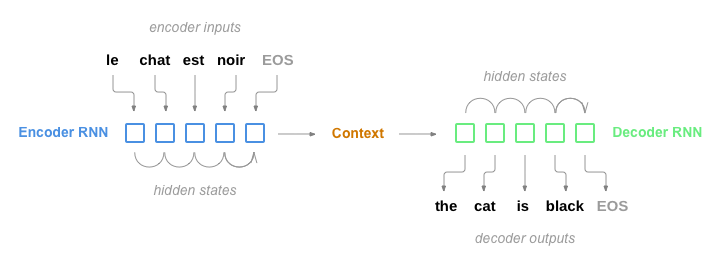

In [32]:
Image("images/s2s.png")

In [33]:
is_cuda = torch.cuda.is_available()

minibatch_size = 8
max_length = 50
n_epochs = 300
learning_rate = 0.001
dropout_p = 0.2
n_layers = 2

hidden_size = 256
embedding_size=256
teacher_forcing_ratio = 0.5
clip = 5.0


In [34]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


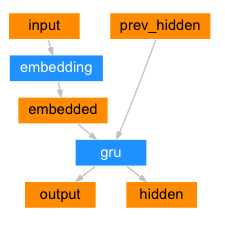

In [35]:
Image("images/encoder.png")

In [36]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size,embedding_size, hidden_size, n_layers=2):
        super(EncoderRNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_size=embedding_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, n_layers)

    def forward(self, word_inputs, hidden):
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.embedding_size))
        if is_cuda: hidden = hidden.cuda()
        return hidden
    

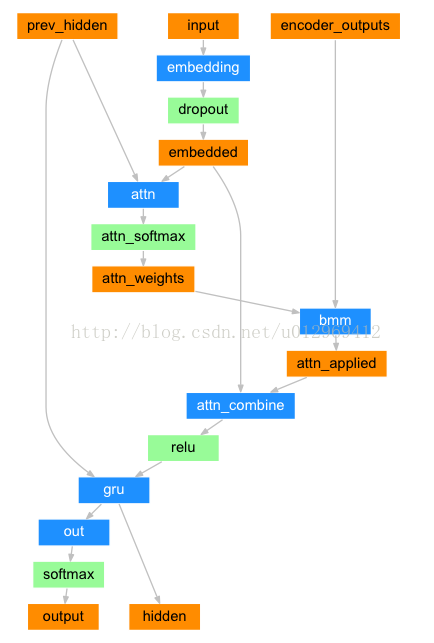

In [37]:
Image("images/attentiondecoder.png")

In [38]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size,output_size=2, n_layers=2, dropout_p=0.1, max_length=50):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size=embedding_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if is_cuda:
            return result.cuda()
        else:
            return result

In [39]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)



In [40]:
def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=50):
    encoder_hidden = encoder.init_hidden()  # 初始化隐藏层
    encoder_optimizer.zero_grad()  # 初始化优化器
    decoder_optimizer.zero_grad()  # 初始化优化器
    loss=0

    input_length = input_variable.size()[0]  # 单个输入语句
    target_length = target_variable.size()[0]  # 单个标签正确翻译后的语句

    # 佔位符 输出长度匹配
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if is_cuda else encoder_outputs

    # 获取encoder对于单个语句的输出
    for ei in range(encoder_outputs.size()[0]):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[0]]))
    decoder_input = decoder_input.cuda() if is_cuda else decoder_input
    decoder_hidden = encoder_hidden

    #透过随机来决定是否执行teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:

        # Teacher forcing: 使用上一期真实的答案来做为本次输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden,encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])  # 计算误差
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: 使用上一期预测结果来做为本期输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if is_cuda else decoder_input
            loss += criterion(decoder_output, target_variable[di])  # 计算误差
            if ni == 1:  break

            # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    reader = sequence_reader()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    n_layers = 2
    dropout_p = 0.05


    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        data_x, data_y = reader.next_minibatch(minibatch_size)

        input_variable = Variable(torch.LongTensor(data_x).view(-1, 1))
        target_variable = Variable(torch.LongTensor(data_y).view(-1, 1))

        if is_cuda:
            input_variable, target_variable = input_variable.cuda(), target_variable.cuda()

        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,max_length=50)

        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) loss:%.4f' % (timeSince(start, iter / n_iters),iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [ ]:
embedding_size = 256
hidden_size = 256
encoder1 = EncoderRNN(len(vocabs), embedding_size ,hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size,embedding_size ,dropout_p=0.1)
trainIters(encoder1, attn_decoder1, 7500, print_every=5)

1m 32s (- 2304m 7s) (5 0%) loss:0.5055
3m 42s (- 2782m 47s) (10 0%) loss:0.1347
5m 56s (- 2967m 15s) (15 0%) loss:0.0127
8m 1s (- 3001m 32s) (20 0%) loss:0.0005
9m 41s (- 2898m 14s) (25 0%) loss:0.0000
11m 30s (- 2865m 13s) (30 0%) loss:0.0000
13m 49s (- 2947m 39s) (35 0%) loss:0.0000
15m 59s (- 2983m 42s) (40 0%) loss:0.0000
17m 49s (- 2952m 58s) (45 0%) loss:0.0000
19m 55s (- 2969m 56s) (50 0%) loss:0.0000
21m 53s (- 2962m 14s) (55 0%) loss:0.0000
23m 53s (- 2963m 30s) (60 0%) loss:0.0000
25m 28s (- 2913m 51s) (65 0%) loss:0.0000
27m 31s (- 2921m 46s) (70 0%) loss:0.0000
29m 17s (- 2900m 8s) (75 1%) loss:0.0000
31m 34s (- 2929m 10s) (80 1%) loss:0.0000
33m 25s (- 2916m 14s) (85 1%) loss:0.0000
35m 15s (- 2902m 26s) (90 1%) loss:0.0000
37m 13s (- 2902m 0s) (95 1%) loss:0.0000
39m 37s (- 2932m 11s) (100 1%) loss:0.0000
41m 33s (- 2926m 27s) (105 1%) loss:0.0000
42m 57s (- 2886m 19s) (110 1%) loss:0.0000
45m 12s (- 2902m 44s) (115 1%) loss:0.0000
46m 57s (- 2887m 53s) (120 1%) loss:0.00